In [1]:
import pandas as pd
from pathlib import Path
import json
from pprint import pprint
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

DATA_DIR = Path("data/benchmarking/nogif")

## Load data


In [2]:
def get_in_road_percentage(steps_df: pd.DataFrame) -> float:
    ret = steps_df["out_of_road"].value_counts(normalize=True).at[False]
    return ret

In [3]:
def get_n_sidewalk_crashes(steps_df: pd.DataFrame) -> int:
    """Count number of crash episodes to not count same crash multiple times"""
    try:
        # count number of times "crash" becomes True for some time
        n_crashes = steps_df["crash_sidewalk"].diff().value_counts().at[True]

        # need to divide by 2 beacouse diff counts twice
        n_crashes /= 2

        # just in case crash is last episode and we have 3.5 crash episodes make it 4
        n_crashes = math.ceil(n_crashes)
    except KeyError:
        n_crashes = 0

    return n_crashes

In [4]:
def process_steps(steps_infos: list) -> dict:
    """Accepts a list of steps and returns a dict of interesting data"""

    steps_df = pd.DataFrame(steps_infos)
    steps_data = {}
    last_step = steps_df.iloc[-1]

    steps_data = {
        "termination.arrive_dest": last_step["arrive_dest"],
        "termination.timeout": last_step["max_step"],
        "route_completion": last_step["route_completion"],
        "seed": last_step["env_seed"],
        "in_road_percentage": get_in_road_percentage(steps_df),
        "n_sidewalk_crashes": get_n_sidewalk_crashes(steps_df),
    }

    return steps_data

In [5]:
def get_scenarios_df(dir: Path):
    paths = list(dir.glob("*/*.json"))

    scenarios = []
    for file_path in tqdm(paths):

        with open(file_path, "r") as f:
            scenario_data = json.load(f)

        dir = file_path.__str__().split("/")[-2]
        _, dr, _, dt = dir.split("_")
        scenario_data["decision_repeat"] = int(dr)
        scenario_data["dt"] = float(dt)

        steps_infos = scenario_data.pop("steps_infos")
        scenario_data.update(process_steps(steps_infos))
        scenarios.append(scenario_data)
    return pd.DataFrame(scenarios)

In [6]:
df = get_scenarios_df(DATA_DIR)

100%|██████████| 1200/1200 [00:04<00:00, 274.67it/s]


In [7]:
df = df.set_index(
    [
        "dt",
        "decision_repeat",
        "seed",
    ],
    verify_integrity=True,
)

df = df.sort_index()

In [8]:
df["n_crashed_vehicles"].describe()
df["n_sidewalk_crashes"].describe()

count    1200.000000
mean        0.556667
std         1.204712
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        11.000000
Name: n_sidewalk_crashes, dtype: float64

In [9]:
# calculate driving score
# ! Problem changing the values here in the analysis can change % error

df["driving_score"] = (
    df["route_completion"]
    * df["in_road_percentage"]
    * (0.65) ** df["n_sidewalk_crashes"]
    * (0.60) ** df["n_crashed_vehicles"]
)

In [10]:
# oracle if the one of default parameters
oracle_ds = df.xs((0.02, 5))["driving_score"]
pd.set_option("display.float_format", lambda x: "%.3f" % x)
oracle_ds.describe()

count   100.000
mean      0.757
std       0.277
min       0.050
25%       0.595
50%       0.989
75%       0.991
max       0.995
Name: driving_score, dtype: float64

In [11]:
df["driving_score_error"] = (df["driving_score"] - oracle_ds).abs()
# df

In [12]:
palette = sns.color_palette("hls", 3)
x_ticks = df.index.get_level_values("decision_repeat").unique().to_list()
x_ticks

[5, 10, 15, 20]

## Original plotting


In [13]:
agg = df.select_dtypes("number").groupby(by=["dt", "decision_repeat"]).mean()
agg

def.max_steps  start_ts  initialized_ts  \
dt    decision_repeat                                            
0.020 5                     2738.680  4050.879        4051.235   
      10                    1369.320  4063.517        4063.867   
      15                     912.860  4072.549        4072.905   
      20                     684.650  4080.325        4080.676   
0.030 5                     1825.790  4056.395        4056.735   
      10                     912.860  4067.182        4067.533   
      15                     608.620  4075.827        4076.181   
      20                     456.450  4083.351        4083.700   
0.040 5                     1369.320  4060.313        4060.657   
      10                     684.650  4070.016        4070.371   
      15                     456.450  4078.385        4078.732   
      20                     342.370  4085.454        4085.800   

                       scenario_done_ts  init_time  scenario_time  total_time  \
dt    decision_repeat                                                           
0.020 5                        4056.094      0.355          4.860       5.215   
      10                       4066.896      0.350          3.029       3.378   
      15                       4075.543      0.356          2.638       2.994   
      20                       4083.068      0.351          2.393       2.744   
0.030 5                        4060.016      0.340          3.281       3.621   
      10                       4069.729      0.350          2.196       2.547   
      15                       4078.107      0.354          1.926       2.280   
      20                       4085.176      0.349          1.476       1.825   
0.040 5                        4063.227      0.343          2.570       2.913   
      10                       4072.263      0.355          1.892       2.247   
      15                       4080.043      0.348          1.310       1.658   
      20                       4086.746      0.345          0.946       1.291   

                       n_crashed_vehicles  route_completion  \
dt    decision_repeat                                         
0.020 5                             0.620             0.967   
      10                            0.650             0.968   
      15                            0.850             0.953   
      20                            0.890             0.972   
0.030 5                             0.620             0.974   
      10                            0.870             0.962   
      15                            1.180             0.914   
      20                            1.210             0.818   
0.040 5                             0.730             0.972   
      10                            1.230             0.940   
      15                            1.430             0.884   
      20                            0.940             0.668   

                       in_road_percentage  n_sidewalk_crashes  driving_score  \
dt    decision_repeat                                                          
0.020 5                             1.000               0.050          0.757   
      10                            1.000               0.070          0.744   
      15                            1.000               0.280          0.642   
      20                            1.000               0.480          0.603   
0.030 5                             1.000               0.130          0.744   
      10                            1.000               0.350          0.635   
      15                            0.998               0.700          0.466   
      20                            0.995               0.890          0.365   
0.040 5                             1.000               0.300          0.685   
      10                            0.999               0.900          0.445   
      15                            0.996               1.180          0.336   
      20                            0.99

In [14]:
# plt.rcParams.update({"font.size": 12})

### RQ1


Text(0.5, 0, 'Decision repeat')

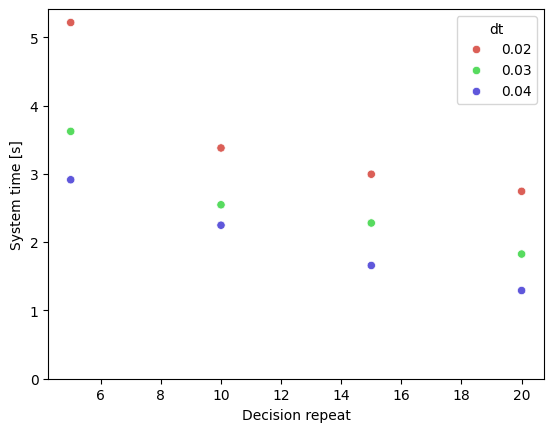

In [15]:
ax = sns.scatterplot(
    agg, x="decision_repeat", y="total_time", hue="dt", palette=palette
)
ax.set_ylim(0)
ax.set_ylabel("System time [s]")
ax.set_xlabel("Decision repeat")
# ax.set_xticks(x_ticks)

### RQ2


Text(0, 0.5, 'Driving Score Error')

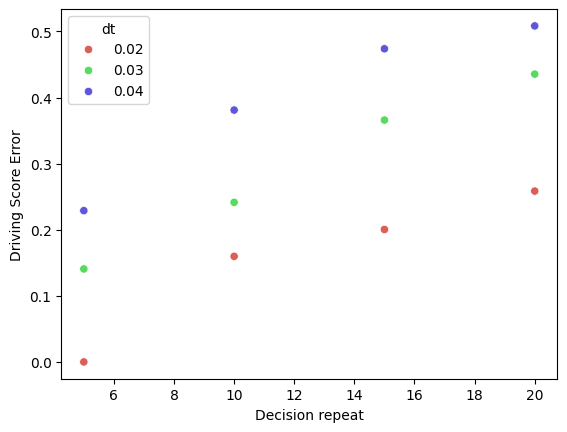

In [16]:
ax = sns.scatterplot(
    agg, x="decision_repeat", y="driving_score_error", hue="dt", palette=palette
)

ax.set_xlabel("Decision repeat")
ax.set_ylabel("Driving Score Error")

## RQ1 and RQ2 on single graph


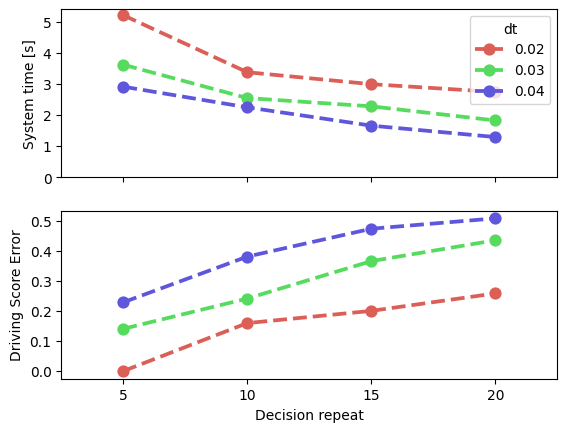

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

ax1 = sns.pointplot(
    agg,
    x="decision_repeat",
    y="total_time",
    hue="dt",
    palette=palette,
    ax=ax1,
    linestyle="--",
)
ax1.set_ylim(0)
ax1.set_ylabel("System time [s]")
ax1.set_xlabel("Decision repeat")


ax2 = sns.pointplot(
    agg,
    x="decision_repeat",
    y="driving_score_error",
    hue="dt",
    palette=palette,
    ax=ax2,
    linestyle="--",
)

ax2.set_xlabel("Decision repeat")
ax2.set_ylabel("Driving Score Error")
ax2.get_legend().remove()

### Pareto optimality RQ1&2


Text(0, 0.5, 'Driving Score Error')

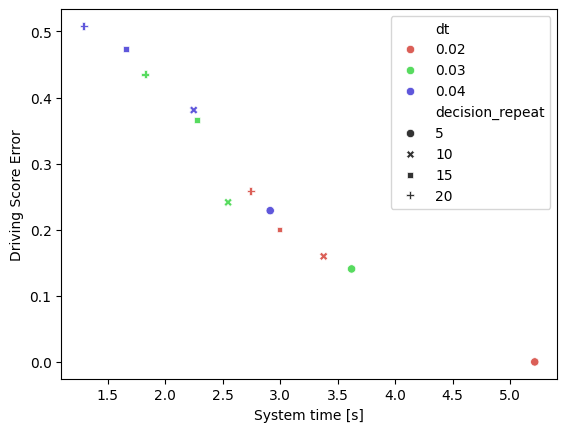

In [18]:
ax = sns.scatterplot(
    agg,
    x="total_time",
    y="driving_score_error",
    style="decision_repeat",
    hue="dt",
    palette=palette,
)

ax.set_xlabel("System time [s]")
ax.set_ylabel("Driving Score Error")